#### Artem Golotin
CS501R Lab 5b

In [1]:
import tensorflow as tf

# Load MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
tf.reset_default_graph()

with tf.name_scope('Wx_B'):
    ### Convolutional and max pooling functions
    conv2d = lambda x, W: tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    max_pool_2x2 = lambda x: tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Placeholders for input data
    I, O = 784, 10
    x = tf.placeholder(tf.float32, shape=[None, I], name='x')
    y_ = tf.placeholder(tf.float32, shape=[None, O], name='y_')
    # Reshape the input image to match the first convolutional input dimentions
    x_image = tf.reshape(x, [-1,28,28,1]) # 28 - width, 28 - height, 1 - color channels

    ### First convolutional layer
    W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1), name='w_conv1')
    b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]), name='bias_conv1')
    # Convolve x_image with the weight tensor + bias, apply ReLU and max pool
    h_conv1 = conv2d(x_image, W_conv1) + b_conv1
    h_relu1 = tf.nn.relu(h_conv1)
    h_pool1 = max_pool_2x2(h_relu1)
    # Interesting to see some histograms
    tf.histogram_summary('hidden_layer_1/activations', h_pool1)

    ### Second convolutional layer
    W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1), name='w_conv2')
    b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]), name='bias_conv2')
    # Convolve h_pool1 with the weight tensor + bias, apply ReLU and max pool
    h_conv2 = conv2d(h_pool1, W_conv2) + b_conv2
    h_relu2 = tf.nn.relu(h_conv2)
    h_pool2 = max_pool_2x2(h_relu2)
    # Interesting to see some historgrams
    tf.histogram_summary('hidden_layer_2/activations', h_pool2)
    

    # Flatten the last layer for a fully connected layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    ### Fully connected layer
    W_fc1 = tf.Variable(tf.truncated_normal([7*7*64, 1024], stddev=0.1), name='w_fully_con1')
    b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]), name='bias_fully_con1')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    ### Dropout layer to avoid overfitting and to calculate correct training accuracy
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    tf.scalar_summary('dropout_keep_probability', keep_prob)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    ### Readout layer and final output
    W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1), name='w_fully_con1')
    b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]), name='bias_fully_con1')
    # Compute final output
    y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='predictions')
    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
with tf.name_scope('cost'):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_pred), reduction_indices=[1]))
    tf.scalar_summary('cost', cross_entropy)
    
with tf.name_scope('optimizer'):
    train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)
    
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.scalar_summary('accuracy', accuracy)

In [3]:
from tqdm import tqdm
import numpy as np

# Run the session
with tf.Session() as sess:
    merged = tf.merge_all_summaries()
    summary_writer = tf.train.SummaryWriter('./tf_logs', graph=sess.graph)
    sess.run(tf.initialize_all_variables())
    for epoch in tqdm(range(1500)):
        # Get next batch
        batch_x, batch_y = mnist.train.next_batch(100)
        if epoch % 10 == 0:
            # Every 10 epochs write out the test set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict={x: batch_x, y_: batch_y, keep_prob: 1.0})
            summary_writer.add_summary(summary, epoch)
        else:
            # Add grayscale to make training more productive
            grayscaled_x = np.apply_along_axis(np.subtract, 0, batch_x, np.average(batch_x, axis=1))
            train_x, train_y = np.vstack((batch_x, grayscaled_x)), np.vstack((batch_y, batch_y))
            # Train
            summary, _ = sess.run([merged, train_step], feed_dict={x: train_x, y_: train_y, keep_prob: 0.8})
            summary_writer.add_summary(summary, epoch)
    # Flush out the summary writer and close it        
    summary_writer.flush()
    summary_writer.close()

100%|██████████| 1500/1500 [51:44<00:00,  2.25s/it]


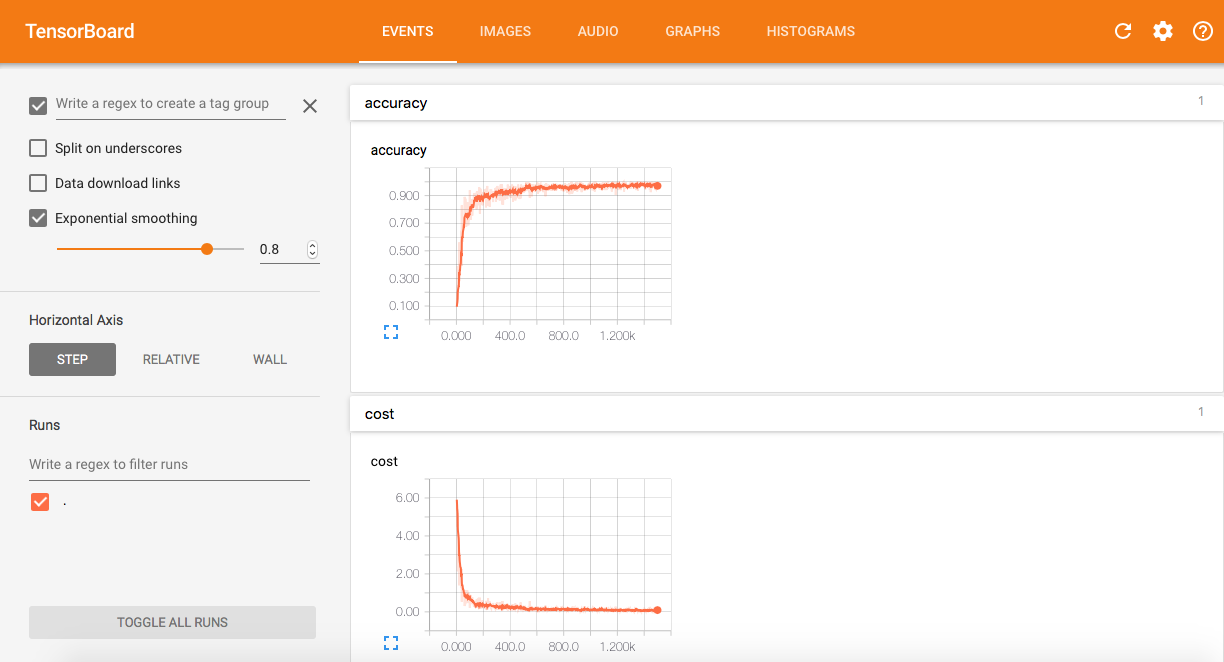

In [6]:
from IPython.display import Image
Image(filename='accuracy.png')

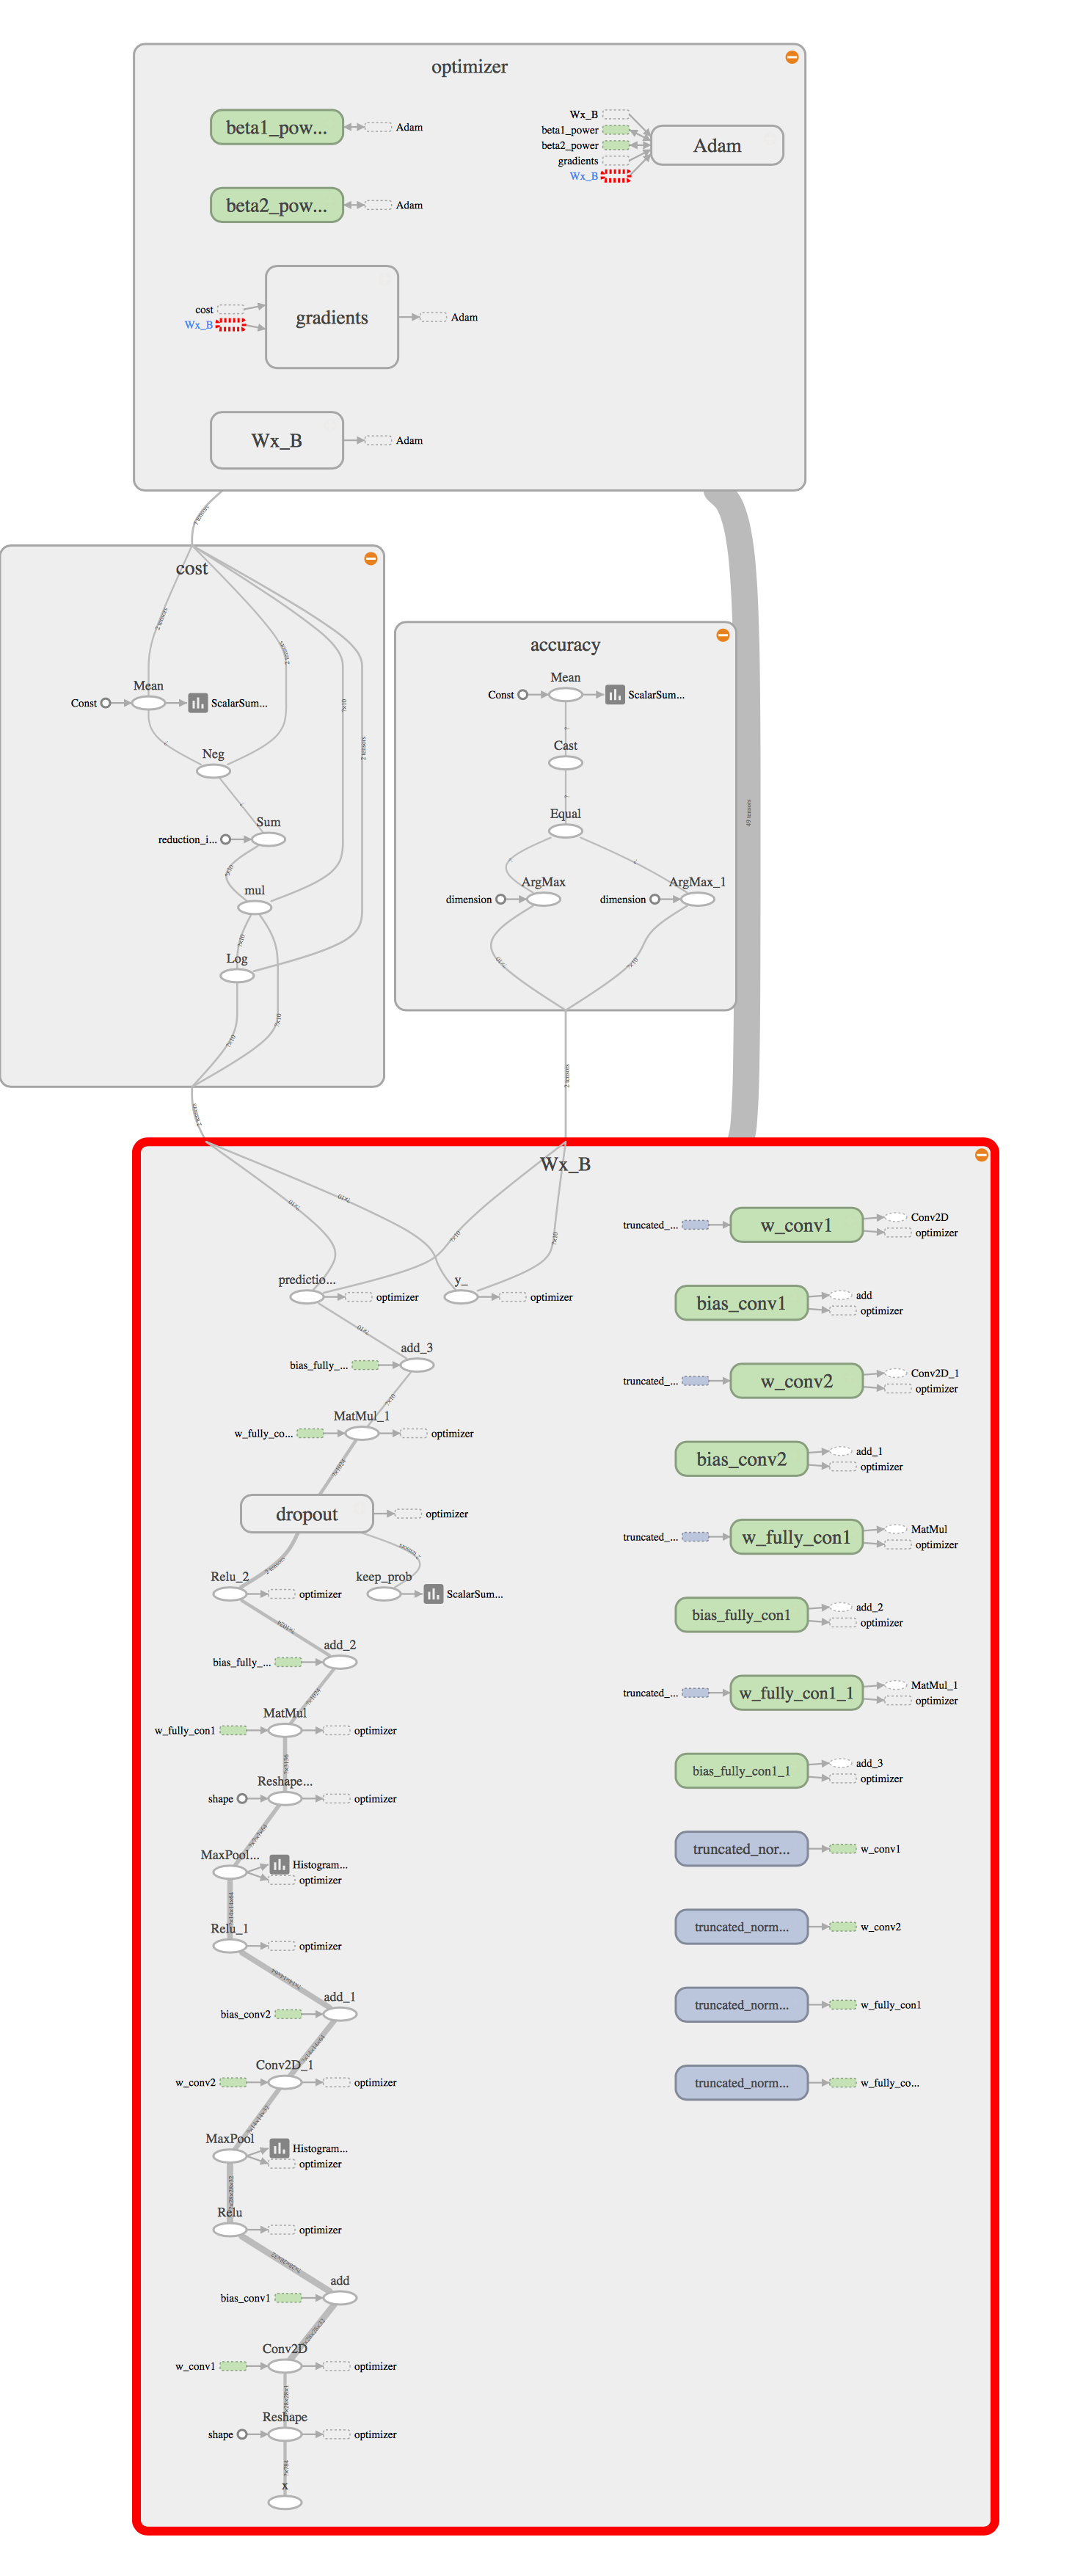

In [5]:
Image(filename='tf_computation_graph.png')